voir pour utiliser la fonction make_pipeline
https://www.geeksforgeeks.org/make_pipeline-function-in-sklearn/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_preprocess = pd.read_csv('../data/predictive_maintenance_preprocess.csv', index_col=0)

Extract the name of variable of 'Target'

In [3]:
name_target_col = list(filter(lambda ligne: 'Target' in ligne, df_preprocess.columns))

Separation of explanatory variables and variables to identify

In [4]:
x = df_preprocess.drop(columns=name_target_col)
y = df_preprocess[name_target_col]

In [5]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [6]:

smote = SMOTE(random_state=12)
X_resampled, y_resampled = smote.fit_resample(x.to_numpy(), y.to_numpy())

In [7]:
unique_values, counts = np.unique(y_resampled, return_counts=True)

In [8]:

X_resampled = pd.DataFrame(X_resampled, columns=x.columns)
y_resampled = pd.DataFrame(pd.get_dummies(y_resampled))
y_resampled.columns=['Target_0', 'Target_1']

In [9]:
#print(np.isnan(X_resampled).any())  # Should print False
print(np.isnan(y_resampled).any())  # Should print False

Target_0    False
Target_1    False
dtype: bool


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

In [11]:
num_features = X_resampled.shape[1]
num_target = y_resampled.shape[1]

In [13]:
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential, Input
from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.optimizer_v2.adam import Adam


In [17]:


from tensorflow.python import keras

keras.backend.clear_session()


EPOCH=80

In [25]:
from tensorflow.python.keras.regularizers import l2, l1
from tensorflow.python.keras.metrics import Accuracy, SparseCategoricalAccuracy, CategoricalAccuracy, AUC, \
    PrecisionAtRecall

model = Sequential()
model.add(Input(num_features))
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l1()))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=num_target, activation='softmax'))

#model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
model.compile(loss=CategoricalCrossentropy(),optimizer=Adam(5e-4), metrics=[PrecisionAtRecall(recall=0.8), Accuracy(), CategoricalAccuracy()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              11264     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [26]:
history=model.fit(X_train.to_numpy(),y_train.to_numpy(),validation_data=(X_test.to_numpy(),y_test.to_numpy()),epochs=EPOCH, batch_size=32)

Epoch 1/80
481/481 [==============================] - 4s 6ms/step - loss: 1.0865 - precision_at_recall: 0.6323 - accuracy: 0.0000e+00 - categorical_accuracy: 0.6733 - val_loss: 0.6319 - val_precision_at_recall: 0.6535 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.7000
Epoch 2/80
481/481 [==============================] - 3s 7ms/step - loss: 0.6084 - precision_at_recall: 0.6668 - accuracy: 0.0000e+00 - categorical_accuracy: 0.7015 - val_loss: 0.6178 - val_precision_at_recall: 0.6579 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.7128
Epoch 3/80
481/481 [==============================] - 4s 8ms/step - loss: 0.5918 - precision_at_recall: 0.6861 - accuracy: 0.0000e+00 - categorical_accuracy: 0.7253 - val_loss: 0.5815 - val_precision_at_recall: 0.6855 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.7291
Epoch 4/80
481/481 [==============================] - 4s 8ms/step - loss: 0.5768 - precision_at_recall: 0.6971 - accuracy: 0.0000e+00 - categorical_accuracy: 0.

In [30]:
history.history.keys()

dict_keys(['loss', 'precision_at_recall', 'accuracy', 'categorical_accuracy', 'val_loss', 'val_precision_at_recall', 'val_accuracy', 'val_categorical_accuracy'])

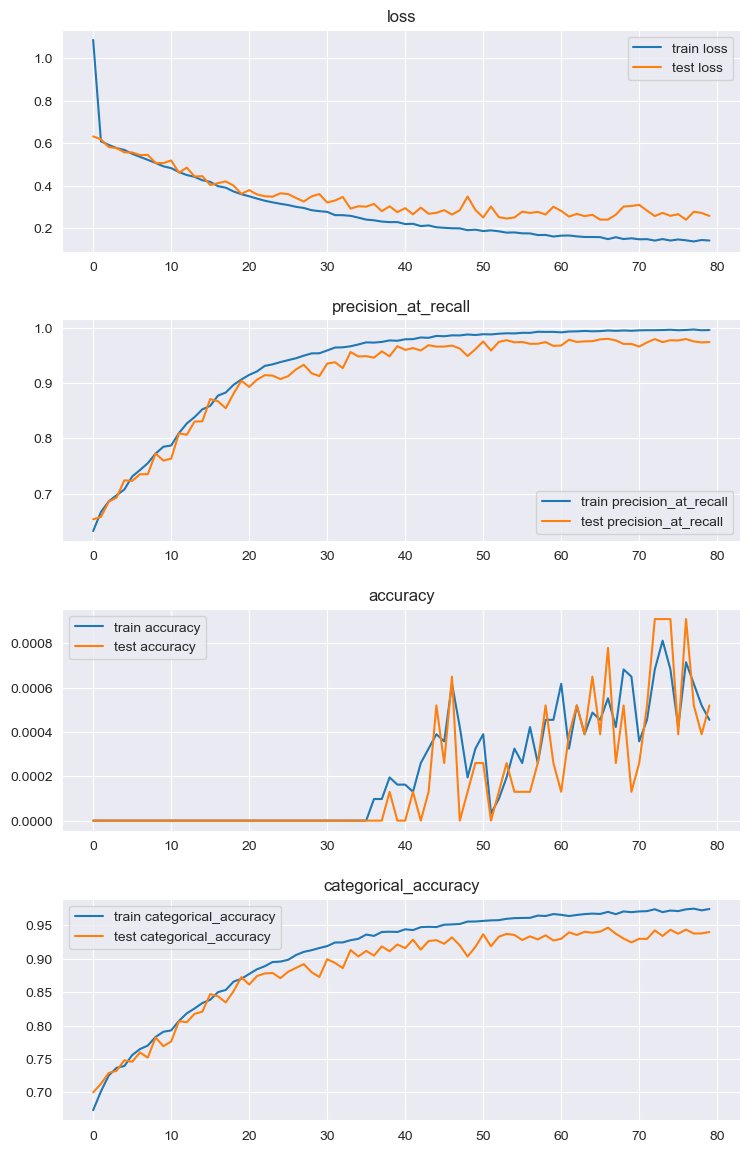

In [49]:
def plot_history(history):
    list_metrics = []
    for st in history.keys():
        if not st.startswith('val'):
            list_metrics.append(st)

    fig, axs = plt.subplots(len(list_metrics), figsize=(8,12))
    fig.tight_layout(pad=3.0)
    
    for i, metrics in enumerate(list_metrics):
        axs[i].plot(np.arange(EPOCH), history[metrics], label='train '+metrics)
        axs[i].plot(np.arange(EPOCH), history['val_'+metrics], label='test '+metrics)
        axs[i].set_title(metrics)
        axs[i].legend()
        
    plt.show()

plot_history(history.history)

In [43]:
y_pred = model.predict(X_test)


In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=np.argmax(y_test.values, axis=1), y_pred=np.argmax(y_pred, axis=1))
print(cm)

[[1857  127]
 [ 103 1760]]


Normalized confusion matrix
[[0.9359879  0.0640121 ]
 [0.05528717 0.94471283]]


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

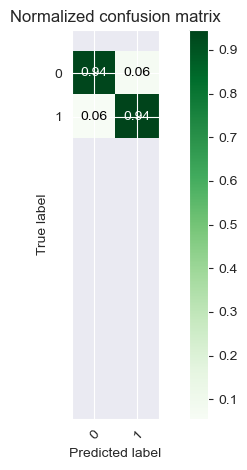

In [47]:
from Advance_plotting import Plotter

plotter = Plotter(class_names=['True', 'False'], model_type='classifier')
plotter.plot_confusion_matrix(y_true=y_test.values, y_pred=y_pred, classes='', normalize=True)